In [22]:
#code I used to rearrange the file from dark sky meter to be the right format
#might be useful again if I re-download the data

import csv

bad_dates = ['2015-03-28 21:30:27', '2015-03-28 22:47:01', '2017-05-15 21:51:37', '2017-04-26 22:18:43', \
             '2017-05-15 21:55:00']

LAT_MIN = 40.35
LAT_MAX = 40.55
LONG_MIN = -80.15
LONG_MAX = -79.8

with open('datasets/dsm_database.csv', 'r') as infile, open('datasets/reordered_dsm.csv', 'w') as outfile:
    # output dict needs a list for new column ordering
    fieldnames = ['_date', '_moon', '_deviceangle', '_lat', '_lng', '_typedesc', '_device', '_nelm','_type','_clouds','_user_tag','_sqm']
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    # reorder the header first
    writer.writeheader()
    for row in csv.DictReader(infile):
        lat = float(list(row.items())[2][1])
        long = float(list(row.items())[3][1])
        date = list(row.items())[0][1]
        if lat > LAT_MIN and lat < LAT_MAX and long > LONG_MIN and long < LONG_MAX and not date in bad_dates:
            # writes the reordered rows to the new file
            writer.writerow(row)
print('done!')

40.386799 -79.927483 2020-07-29 02:49:56
40.400917 -79.950928 2020-07-29 02:41:17
40.401585 -79.951492 2020-07-29 02:40:43
40.420078 -79.957451 2020-07-29 02:26:33
40.409321 -79.963638 2020-07-29 02:17:39
40.399532 -79.967628 2020-07-29 02:06:25
40.395176 -79.970924 2020-07-29 02:02:20
40.393078 -79.968849 2020-07-29 02:00:49
40.390839 -79.966965 2020-07-29 01:59:17
40.390835 -79.966904 2020-07-29 01:58:42
40.38998 -79.964912 2020-07-29 01:57:10
40.390598 -79.949211 2020-07-29 01:51:45
40.389771 -79.935966 2020-07-29 01:48:30
40.386406 -79.93206 2020-07-29 01:44:50
40.387115 -79.929947 2020-07-29 01:42:04
40.386852 -79.927528 2020-07-29 01:35:21
40.38686 -79.927513 2020-07-29 01:34:43
40.386837 -79.927483 2020-06-20 23:59:40
40.386837 -79.927498 2020-06-20 23:58:31
40.386944 -79.927605 2020-06-20 23:57:31
40.386826 -79.927475 2020-06-16 03:53:57
40.386806 -79.927437 2020-06-16 03:53:04
40.465092 -79.932693 2020-05-18 03:13:36
40.386868 -79.92749 2020-04-02 01:26:38
40.386822 -79.927429

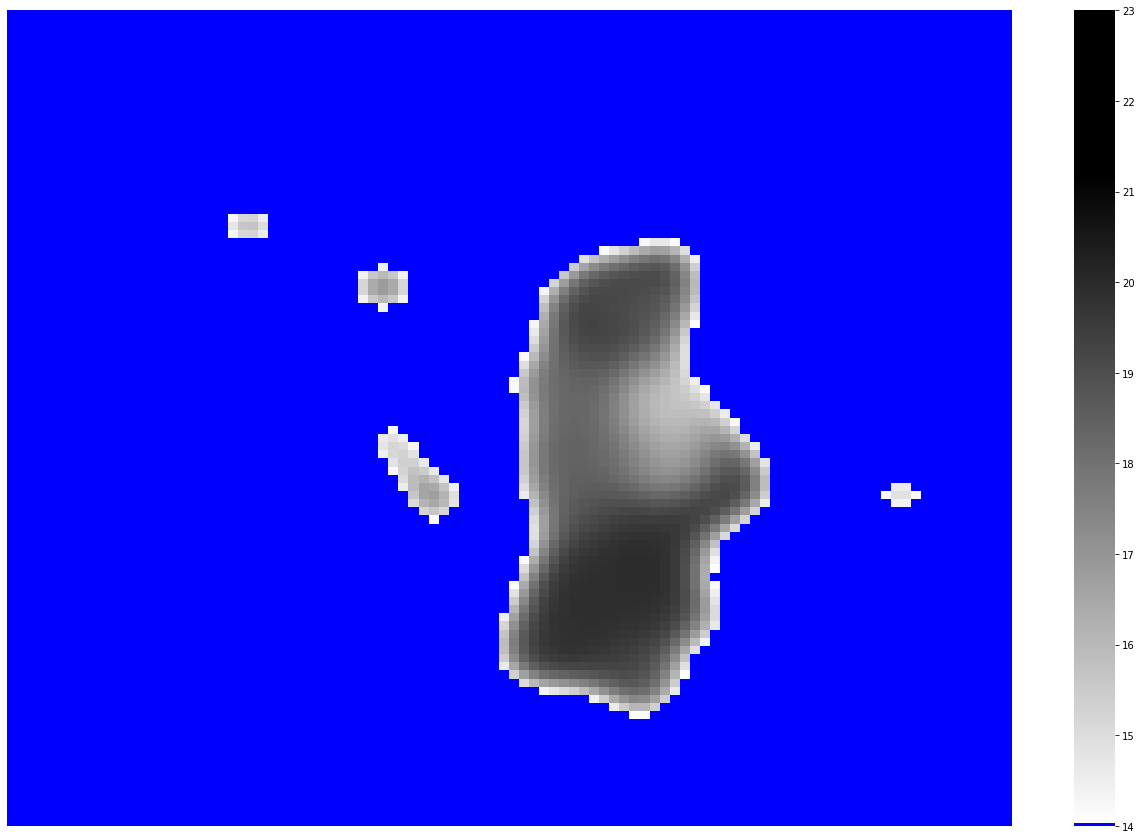

In [5]:
#code used for generating heat maps

import csv
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import math

#these are aesthetic and can be adjusted as you see fit
#higher dimensions can take a while so use 100 and 5 for testing
DIM = 100
RADIUS = 5
SIGMA = RADIUS/2
#boundaries of the image
LAT_MIN = 40.35
LAT_MAX = 40.55
LONG_MIN = -80.15
LONG_MAX = -79.8

#latitude = row[3]
#longitude = row[4]
#sqm = row[11]

file_names = ['GaN2019.csv', 'GaN2018.csv', 'GaN2017.csv', 'GaN2016.csv', 'GaN2015.csv', 'GaN2014.csv',\
             'GaN2013.csv', 'GaN2012.csv', 'GaN2011.csv', 'GaN2010.csv', 'reordered_dsm.csv']

data = np.zeros((DIM, DIM))

averages = [[0] * DIM for i in range(DIM)]

def NonLinCdict(steps, hexcol_array):
    cdict = {'red': (), 'green': (), 'blue': ()}
    for s, hexcol in zip(steps, hexcol_array):
        rgb =matplotlib.colors.hex2color(hexcol)
        cdict['red'] = cdict['red'] + ((s, rgb[0], rgb[0]),)
        cdict['green'] = cdict['green'] + ((s, rgb[1], rgb[1]),)
        cdict['blue'] = cdict['blue'] + ((s, rgb[2], rgb[2]),)
    return cdict

#graysale
hc = ['#0000ff', '#ffffff','#000000', '#000000']
th = [0, 0.001, 0.8, 1]

cdict = NonLinCdict(th, hc)
cm = matplotlib.colors.LinearSegmentedColormap('test', cdict)

def add_data_pt(avg_list, lat, long, sqm):
    if isinstance(avg_list[lat][long], list):
        cur_val = avg_list[lat][long][0]
        num_data_pts = avg_list[lat][long][1]
        avg_list[lat][long][0] = sqm #((num_data_pts*cur_val)+sqm)/(num_data_pts+1) #average
        avg_list[lat][long][1] += 1
    else:
        avg_list[lat][long] = [sqm, 1]
        
def add_radius(avg_list, lat, long, sqm, radius):
    for x in range(DIM):
        for y in range(DIM):
            distance = math.sqrt((x-long)**2 + (y-lat)**2)
            if distance <= radius:
                add_data_pt(avg_list, x, y, sqm)
        
for file_name in file_names:
    with open('datasets/' + file_name) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            try: #some of the rows are empty/have missing values which causes errors, we can skip those lines
                if float(row[3]) < LAT_MAX and float(row[3]) > LAT_MIN and float(row[4]) < LONG_MAX and float(row[4]) > LONG_MIN:
                    #remember that since longitude is negative, the heatmap is actually reversed.
                    #^ this problem is solved by subtracting long from DIM.
                    lat = DIM*(LAT_MAX-float(row[3]))/(LAT_MAX-LAT_MIN)
                    long = DIM - DIM*(LONG_MAX-float(row[4]))/(LONG_MAX-LONG_MIN)
                    #print(lat, long)
                    add_radius(averages, long, lat, float(row[11]), RADIUS)
            except:
                pass

for x in range(DIM):
    for y in range(DIM):
        try: 
            data[x][y] = averages[x][y][0]
        except:
            data[x][y] = 0

from scipy.ndimage.filters import gaussian_filter
data = gaussian_filter(data, sigma=SIGMA)

with open("fulldataset.csv", 'w+') as dataset:
    dataWriter = csv.writer(dataset,delimiter=',')
    dataWriter.writerows(data)

plt.subplots(figsize=(22.5,15))
heat_map = sb.heatmap(data, cmap=cm, vmin=14, vmax=23, alpha=1, xticklabels=False, yticklabels=False)
plt.savefig("heatmap2.png")

# get the map image as an array so we can plot it 
import matplotlib.image as mpimg 

map_img = mpimg.imread('heatmap2.png')
#map_img_bottom = mpimg.imread('img/bigger-map-all.png') 
#map_img_mid = mpimg.imread('img/bigger-map-gray-border-only2.png')
#map_img_top = mpimg.imread('img/bigger-map-gray-border-only.png')

hmax = heat_map

#hmax.imshow(map_img_bottom,
#          aspect = hmax.get_aspect(),
#          extent = hmax.get_xlim() + hmax.get_ylim(),
#          zorder = 0)
#hmax.imshow(map_img_mid,
#          aspect = hmax.get_aspect(),
#          extent = hmax.get_xlim() + hmax.get_ylim(),
#          zorder = 1) #put the transparent map over the heatmap
#hmax.imshow(map_img_top,
#          aspect = hmax.get_aspect(),
#          extent = hmax.get_xlim() + hmax.get_ylim(),
#          zorder = 1) #put the transparent map over the heatmap

plt.savefig("heatmap2.png")
plt.show()

In [9]:
import os

ALPHA = 0.85
BW = False

HMAP_UNDERLAY = "img/heatmap-underlay.png" if BW else "img/heatmap-underlay2.png"

import matplotlib.image as mpimg 

from PIL import Image

img = Image.open('heatmap2.png')
img = img.convert("RGBA")

pixdata = img.load()

width, height = img.size
for y in range(height):
    for x in range(width):
        px = pixdata[x,y]
        if px[2] > px[0]*2 and px[2] > px[1]*2\
            or (px[0] > 220 and px[1] > 220 and px[2] > 220):
            pixdata[x, y] = (255, 255, 255, 0)
        else:
            pixdata[x, y] = (px[0], px[1], px[2], int(255*ALPHA))

#img.save("border-overlay5.png", "PNG")
img.save("midlay.png", "PNG")

underlay = Image.open(HMAP_UNDERLAY)
overlay = Image.open('img/border-overlay3.png')
overlay2 = Image.open('img/border-overlay5.png')
midlay = Image.open('midlay.png')

underlay = Image.alpha_composite(underlay, Image.alpha_composite(midlay, Image.alpha_composite(overlay, overlay2)))
os.remove("midlay.png")
underlay.save("heatmap.png", "PNG")

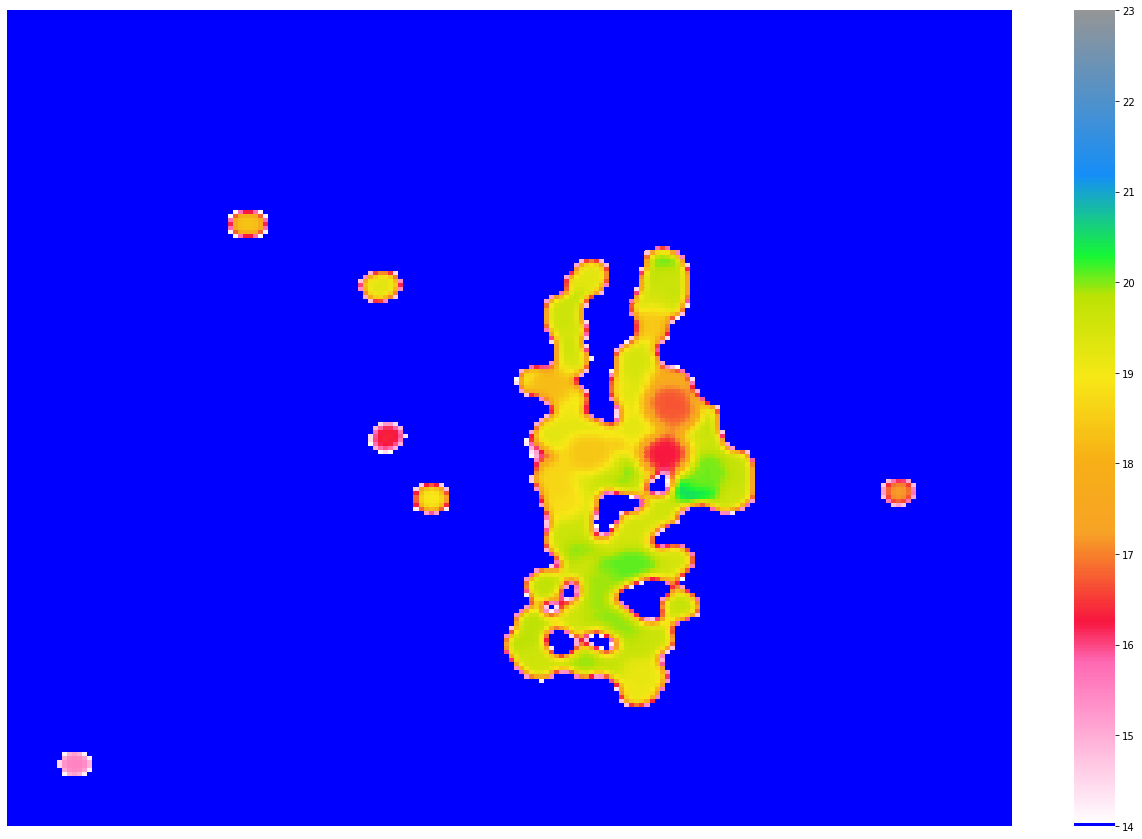

In [23]:
#code used for generating heat maps

import csv
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import math

#these are aesthetic and can be adjusted as you see fit
#higher dimensions can take a while so use 100 and 5 for testing
DIM = 200
RADIUS = 5
SIGMA = RADIUS/4
#boundaries of the image
LAT_MIN = 40.35
LAT_MAX = 40.55
LONG_MIN = -80.15
LONG_MAX = -79.8

#latitude = row[3]
#longitude = row[4]
#sqm = row[11]

file_names = ['GaN2019.csv', 'GaN2018.csv', 'GaN2017.csv', 'GaN2016.csv', 'GaN2015.csv', 'GaN2014.csv',\
             'GaN2013.csv', 'GaN2012.csv', 'GaN2011.csv', 'GaN2010.csv', 'reordered_dsm.csv']

data = np.zeros((DIM, DIM))

averages = [[0] * DIM for i in range(DIM)]

def NonLinCdict(steps, hexcol_array):
    cdict = {'red': (), 'green': (), 'blue': ()}
    for s, hexcol in zip(steps, hexcol_array):
        rgb =matplotlib.colors.hex2color(hexcol)
        cdict['red'] = cdict['red'] + ((s, rgb[0], rgb[0]),)
        cdict['green'] = cdict['green'] + ((s, rgb[1], rgb[1]),)
        cdict['blue'] = cdict['blue'] + ((s, rgb[2], rgb[2]),)
    return cdict

#without countours
hc = ['#0000ff', '#ffffff', '#FF69B4', '#f7163f', '#f7a325', '#f7b016', '#f7e816', '#bde204', '#16f734', '#168ef7', '#939596'] #COLORS
th = [0, 0.001, 0.2, 0.25, 0.36, 0.45, 0.55, 0.65, 0.7, 0.8, 1]

#with contours
#hc = ['#a0a0a0', '#ffffff', '#ffffff','#000000', '#FF69B4', '#f7163f', '#f7163f', '#000000', \
#      '#f7a325', '#f7b016', '#f7b016', '#000000', '#f7e816', '#f7e816', '#000000', '#bde204', '#16f734', '#16f734', '#000000', '#168ef7', '#939596'] #COLORS
#th = [0, 0.1, 0.193, 0.195, 0.2, 0.25, 0.353, 0.354, 0.36, 0.45, 0.543, 0.545, 0.55, 0.643, 0.645, 0.65, 0.7, 0.793, 0.796, 0.8, 1] #thresholds

cdict = NonLinCdict(th, hc)
cm = matplotlib.colors.LinearSegmentedColormap('test', cdict)

def add_data_pt(avg_list, lat, long, sqm):
    if isinstance(avg_list[lat][long], list):
        cur_val = avg_list[lat][long][0]
        num_data_pts = avg_list[lat][long][1]
        avg_list[lat][long][0] = sqm #((num_data_pts*cur_val)+sqm)/(num_data_pts+1) #average
        avg_list[lat][long][1] += 1
    else:
        avg_list[lat][long] = [sqm, 1]
        
def add_radius(avg_list, lat, long, sqm, radius):
    for x in range(DIM):
        for y in range(DIM):
            distance = math.sqrt((x-long)**2 + (y-lat)**2)
            if distance <= radius:
                add_data_pt(avg_list, x, y, sqm)
        
for file_name in file_names:
    with open('datasets/' + file_name) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            try: #some of the rows are empty/have missing values which causes errors, we can skip those lines
                if float(row[3]) < LAT_MAX and float(row[3]) > LAT_MIN and float(row[4]) < LONG_MAX and float(row[4]) > LONG_MIN:
                    #remember that since longitude is negative, the heatmap is actually reversed.
                    #^ this problem is solved by subtracting long from DIM.
                    lat = DIM*(LAT_MAX-float(row[3]))/(LAT_MAX-LAT_MIN)
                    long = DIM - DIM*(LONG_MAX-float(row[4]))/(LONG_MAX-LONG_MIN)
                    #print(lat, long)
                    add_radius(averages, long, lat, float(row[11]), RADIUS)
            except:
                pass

for x in range(DIM):
    for y in range(DIM):
        try: 
            data[x][y] = averages[x][y][0]
        except:
            data[x][y] = 0

from scipy.ndimage.filters import gaussian_filter
data = gaussian_filter(data, sigma=SIGMA)

with open("fulldataset.csv", 'w+') as dataset:
    dataWriter = csv.writer(dataset,delimiter=',')
    dataWriter.writerows(data)

plt.subplots(figsize=(22.5,15))
heat_map = sb.heatmap(data, cmap=cm, vmin=14, vmax=23, alpha=1, xticklabels=False, yticklabels=False)
#plt.show()

# get the map image as an array so we can plot it 
import matplotlib.image as mpimg 
map_img_bottom = mpimg.imread('img/bigger-map-all.png') 
map_img_top = mpimg.imread('img/bigger-map-gray.png')

hmax = heat_map

#hmax.imshow(map_img_bottom,
#          aspect = hmax.get_aspect(),
#          extent = hmax.get_xlim() + hmax.get_ylim(),
#          zorder = 1) #put the map under the heatmap
#hmax.imshow(map_img_top,
#          aspect = hmax.get_aspect(),
#          extent = hmax.get_xlim() + hmax.get_ylim(),
#          zorder = 1) #put the transparent map over the heatmap


plt.savefig("heatmap2.png")
plt.show()